In [2]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
import sys
import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
GPU = 1

In [5]:
pwd

'/home/etheredge/Workspace/VisionEngine/notebooks'

In [6]:
checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_finetune/2020-226-10/guppy_nouveau_finetune.hdf5"

In [7]:
config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_nouveau_finetune_config.json"
config = process_config(config_file)

In [8]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [9]:
with tf.device(f'/device:GPU:{GPU}'):
    model = factory.create(
                "VisionEngine.models."+config.model.name
                )(config)

model.trainable = False

importing VisionEngine.models.nouveau_vae_model
getattr VAEModel
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:

In [10]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_finetune/2020-226-10/guppy_nouveau_finetune.hdf5 ...

Model loaded


In [11]:
config.data_loader.use_generated = False
config.data_loader.use_real = True


config.data_loader.shuffle = False

In [12]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [13]:
def plot_im(img):
    if config.model.last_activation == 'tanh':
        img * 0.5 + 0.5
        return img
    else:
        return img

def plot_img_attributions(image,
                          attribution_mask,
                          H=0,
                          z_i=0,
                          cmap=None,
                          overlay_alpha=0.4):

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(12, 4))

    axs[0, 0].set_title('Original sample Output')
    axs[0, 0].imshow(image)
    axs[0, 0].axis('off')

    axs[0, 1].set_title(f'Attribution mask: {H}, {z_i}')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].axis('off')

    axs[0, 2].set_title(f'Overlay: {H}, {z_i}')
    axs[0, 2].imshow(attribution_mask, cmap=cmap)
    axs[0, 2].imshow(image, alpha=overlay_alpha)
    axs[0, 2].axis('off')

    plt.tight_layout()
    return fig

def plot_overlay(image,
                 attribution_mask,
                 H=0,
                 z_i=0,
                 cmap=None,
                 overlay_alpha=0.4):

    fig, axs = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(4, 4))
    axs[0, 0].set_title(f'Overlay: {H}, {z_i}')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].imshow(image, alpha=overlay_alpha)
    axs[0, 0].axis('off')
    plt.tight_layout()
    return fig

In [14]:
def embed_images(x):
    outputs = [
        model.model.get_layer('variational_layer').output,
        model.model.get_layer('variational_layer_1').output,
        model.model.get_layer('variational_layer_2').output,
        model.model.get_layer('variational_layer_3').output
    ]
    encoder = tf.keras.Model(model.model.inputs, outputs)
    return encoder.predict(x)

def reconstruct_images(x):
    return model.model.predict(x)

In [21]:
def interpolate_latentvar(Z, H, z_i, alphas, zdim=10):
    mods = []
    for h in range(len(Z)):
        if h == H:
            z = Z[h]
            mod = tf.concat([
                tf.repeat(
                    [z], 10, axis=0)[:,-1:z_i],
                alphas[:, tf.newaxis],
                tf.repeat(
                    [z], 10, axis=0)[:, z_i:-1]], axis=1)
            mods.append(mod)
        else:
            z = Z[h]
            mod = tf.repeat([z], 10, axis=0)
            mods.append(mod)

    return mods

def compute_gradients(latent_vars):
    with tf.GradientTape() as tape:
        tape.watch(latent_vars)
        logits = model.decoder([latent_vars[0], latent_vars[1], latent_vars[2], latent_vars[3]])
        images = tf.nn.softmax(logits, axis=-1) # alt tf.nn.sigmoid, tf.nn.tanh
    return tape.gradient(images, logits)


def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients


@tf.function
def integrated_gradients(encoding, H=0, z_i=0, m_steps=300, batch_size=10, lim=1.):

    # Generate traversal steps
    traversal_steps = tf.linspace(start=-lim, stop=lim, num=m_steps)
    

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch traversals
    ds = tf.data.Dataset.from_tensor_slices(traversal_steps).batch(batch_size)

    for batch in ds:
        batch_interpolated_inputs = interpolate_latentvar(Z=encoding, H=H, z_i=z_i, alphas=batch)

        batch_gradients = compute_gradients(batch_interpolated_inputs)

        integrated_gradients += integral_approximation(gradients=batch_gradients)
    
    return 2 * tf.abs(lim) * integrated_gradients

In [15]:
with tf.device(f'/device:GPU:{GPU}'):
    # encode the samples
    z = tf.convert_to_tensor(embed_images(data_loader.get_test_data()))

Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset i

In [18]:
with tf.device(f'/device:GPU:{GPU}'):
    print(tf.math.reduce_max(z))

tf.Tensor(235.50194, shape=(), dtype=float32)


In [17]:
with tf.device(f'/device:GPU:{GPU}'):
    images_ = iter(data_loader.get_test_data())

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

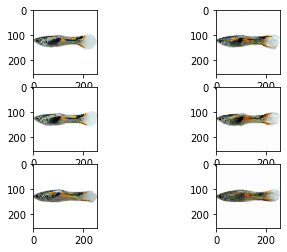

In [19]:
with tf.device(f'/device:GPU:{GPU}'):
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(321)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(322)
    plt.imshow(plot_im(x_hat[ID]))
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(323)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(324)
    plt.imshow(plot_im(x_hat[ID]))
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(325)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(326)
    plt.imshow(plot_im(x_hat[ID]))

In [ ]:
  # < 16 we're only grabbing one batch at a time
plt.subplot(121)
plt.imshow(list(x)[0][0][sample_id])
plt.subplot(122)
plt.imshow(x_hat[sample_id])

In [20]:
sample_id = 8
hierarchical_level = 4
encoding_axis = 0

In [23]:
with tf.device(f'/device:GPU:{GPU}'):
    # compute atributions by integrating the gradients
    attributions = integrated_gradients(z[:,sample_id,:], H=hierarchical_level, z_i=encoding_axis)

    # visualize the attributions
    attributions_mask = tf.reduce_sum(tf.math.abs(attributions), axis=[0, -1])


Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:1


TypeError: in user code:

    <ipython-input-21-00b5706a4964>:39 integrated_gradients  *
        traversal_steps = tf.linspace(start=-5, stop=5, num=m_steps)
    /home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:5135 lin_space  **
        "LinSpace", start=start, stop=stop, num=num, name=name)
    /home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:578 _apply_op_helper
        param_name=input_name)
    /home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:61 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'start' has DataType int32 not in list of allowed values: bfloat16, float16, float32, float64


In [ ]:
_ = plot_img_attributions(image=x_hat[sample_id],
                          attribution_mask=attributions_mask,
                          H=hierarchical_level,
                          z_i=encoding_axis,
                          cmap=plt.cm.Greys,
                          overlay_alpha=0.5)

In [ ]:
for att in attributions:
    try:
        print(att.shape)
    except AttributeError:
        print(att)

In [ ]:
attributions.shape

In [ ]:
attributions_mask_ = tf.reduce_sum(tf.math.abs(attributions), axis=[0, -1])

In [ ]:
plt.imshow(attributions_mask)

In [ ]:
plt.cm.